# Raster packages demo: Rasterio (2/3)

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean, Eric Gagliano, Quinn Brencher

## Introduction

Working with raster data is a essential part of geospatial analysis. There are several python packages available for raster processing, and we'll introduce three key tools that build on top of each other...

* GDAL (Geospatial Data Abstraction Library): The low-level foundation that powers most geospatial software. While powerful, it can be complex to use directly.
* rasterio: A more Pythonic interface to GDAL that provides efficient access to raster data using NumPy arrays.
* rioxarray: Higher-level package that combines the power of rasterio with xarray's labeled dimensions and advanced capabilities for handling multi-dimensional data. 

Each package plays an important role in the python geospatial ecosystem, so we'll briefly introduce the tools one at a time to practice some fundamentals and gain some raster intuition. 

*The lower level GDAL and rasterio are very well-supported, and there are indeed use cases for when you might prefer interacting with these lower level tools. Ultimately, we'll focus on rioxarray for the rest of the quarter due to its intuitive handling of multi-dimensional data (e.g. raster time series) and dask integration for scalability.*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio as rio
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib_scalebar.scalebar import ScaleBar


In [2]:
imgdir = f'{Path.home()}/gda_demo_data/LS8_data'

#Pre-identified cloud-free Image IDs used for the lab
august_id = 'LC08_L2SP_046027_20180818_20200831_02_T1' # August 2018

# B10 is the thermal infrared /surface temperture band
tir_august_fn = os.path.join(imgdir, august_id+'_ST_B10.TIF')
tir_august_4326_fn = os.path.join(imgdir, august_id+'_ST_B10_4326.TIF')

print(tir_august_fn)

/home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF


## rasterio

Rasterio, developed and supported by Mapbox, builds on top of GDAL’s many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved. You can check out the quickstart tutorial [here](https://rasterio.readthedocs.io/en/stable/quickstart.html).

### Open the raster with rasterio
* Can either use a Python `with` construct to cleanly open, inspect, and close the file directly from the url, or, you can open the dataset for persistent and interactive access
    * `with` enables more elegant file opening/closing and handling errors (like missing files)
    * opening without the `with` is likely a better option as you're learning, as you can access the opened dataset and arrays you've already read in other cells
    * We will temporarily store the rasterio dataset with variable name `src` (short for "source")
    * Remember to close the rasterio dataset when no longer needed!

In [3]:
# with rio.open(tir_fn) as src:
#     print(src.profile)

src = rio.open(tir_august_fn)
src

<open DatasetReader name='/home/eric/LS8_data/LC08_L2SP_046027_20180818_20200831_02_T1_ST_B10.TIF' mode='r'>

In [4]:
type(src)

rasterio.io.DatasetReader

In [5]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7771, 'height': 7891, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'), 'transform': Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [6]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 7771,
 'height': 7891,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'),
 'transform': Affine(30.0, 0.0, 473685.0,
        0.0, -30.0, 5373615.0)}

In [7]:
src.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

### Plot using rasterio `show()` function
* Note axes tick labels

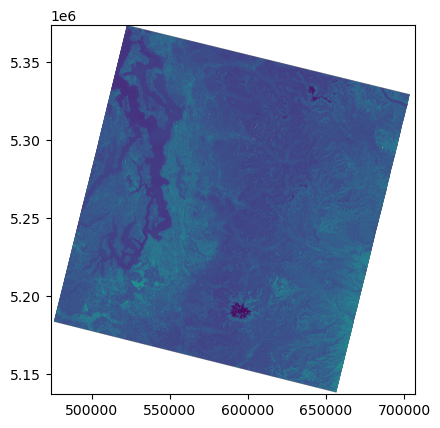

In [8]:
rasterio.plot.show(src);

### Read the array

In [9]:
#src.read?

In [10]:
#Note memory usage before and after reading
%time
a = src.read(1)
a

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 13.1 μs


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [11]:
a.shape

(7891, 7771)

### Plot using Matplotlib `imshow`
* Note axes tick labels

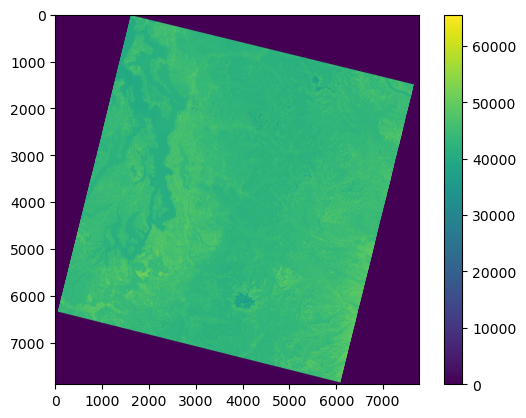

In [12]:
f,ax = plt.subplots()
m = ax.imshow(a)
f.colorbar(m, ax=ax);

## Inspect the array

In [13]:
a.shape

(7891, 7771)

In [14]:
a.size

61320961

In [15]:
a.dtype

dtype('uint16')

In [16]:
a.min()

0

In [17]:
a.max()

65535

In [18]:
2**16

65536

In [19]:
a.shape

(7891, 7771)

In [20]:
#Convert to 1D (needed for histogram)
a.ravel().shape

(61320961,)

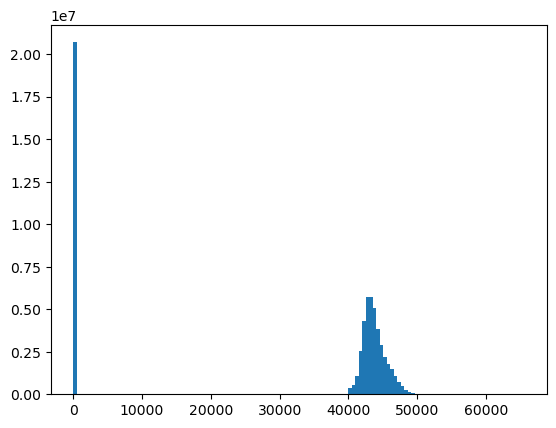

In [21]:
f, ax = plt.subplots()
ax.hist(a.ravel(), bins=128);

### Use a masked array to handle nodata

In [22]:
src.nodata

0.0

In [23]:
#If nodata is defined, rasterio can created masked array when reading
src.read(1, masked=True)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [24]:
#Can also create from existing NumPy array
#np.ma.masked_equal?

In [25]:
a = np.ma.masked_equal(a, 0)
a

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

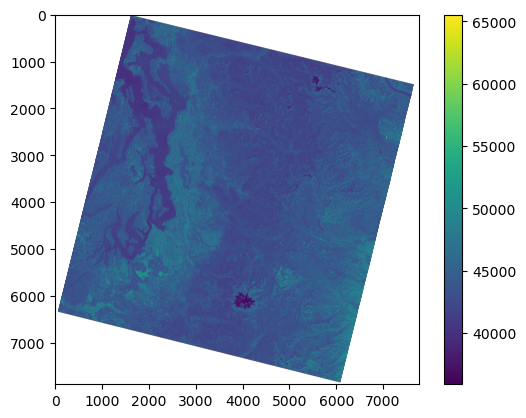

In [26]:
f,ax = plt.subplots()
m = ax.imshow(a)
f.colorbar(m, ax=ax);

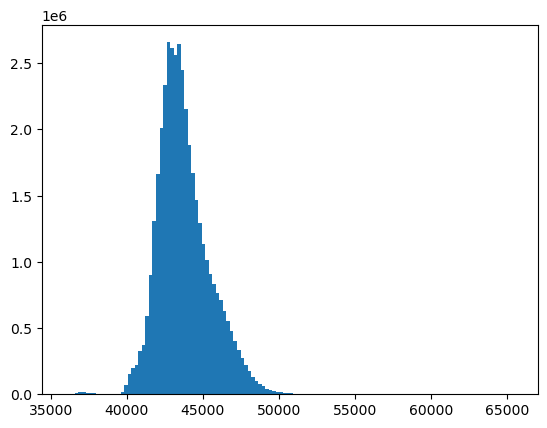

In [27]:
f, ax = plt.subplots()
ax.hist(a.compressed(), bins=128);

### Scaling 16-bit values to geophysical variables - surface reflectance and temperature
* Use raster math to multiply by scaling factor and add offset value
* See conversion factors [here](https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products)
* Units:
    * Unitless surface reflectance values from 0.0 to 1.0
    * Surface temperature values in Kelvin - can convert to Celsius

In [28]:
#These are the standard scale and offset values
#SR 0.0000275 + -0.2
sr_scale = 0.0000275
sr_offset = -0.2
#ST 0.00341802 + 149.0
st_scale = 0.00341802
st_offset = 149.0

In [29]:
#We are working with Thermal IR band, so let's use the thermal scale and offset
a_st = a * st_scale + st_offset

In [30]:
#Convert to Celsius
a_st = a_st - 273.15

In [31]:
a_st.dtype

dtype('float64')

In [32]:
a_st.min()

-1.4294099200000119

In [33]:
#Float32 should provide enough precision for these data
a_st = a_st.astype('float32')

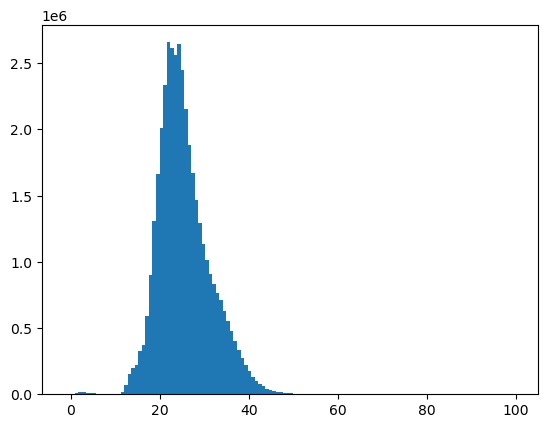

In [34]:
f, ax = plt.subplots()
plt.hist(a_st.compressed(), bins=128);

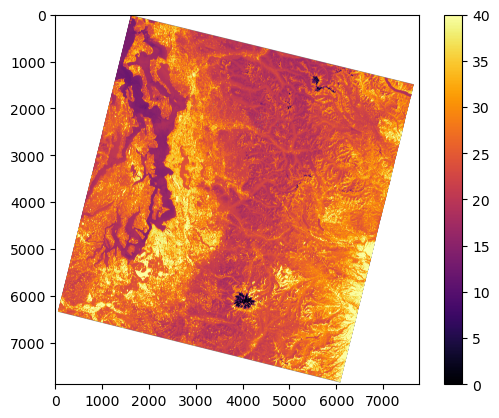

In [35]:
f, ax = plt.subplots()
m = ax.imshow(a_st, vmin=0, vmax=40, cmap='inferno')
f.colorbar(m, ax=ax);

### Bounds and extent

In [36]:
#This is rasterio bounds object in projected units (meters) - note labels like dictionary keys and values
src.bounds

BoundingBox(left=473685.0, bottom=5136885.0, right=706815.0, top=5373615.0)

In [37]:
#This is matplotlib extent
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[473685.0, 706815.0, 5136885.0, 5373615.0]


In [38]:
#rasterio convenience function
full_extent = rio.plot.plotting_extent(src)
print(full_extent)

(473685.0, 706815.0, 5136885.0, 5373615.0)


### Plot the image with matplotlib `imshow`, but now pass in this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

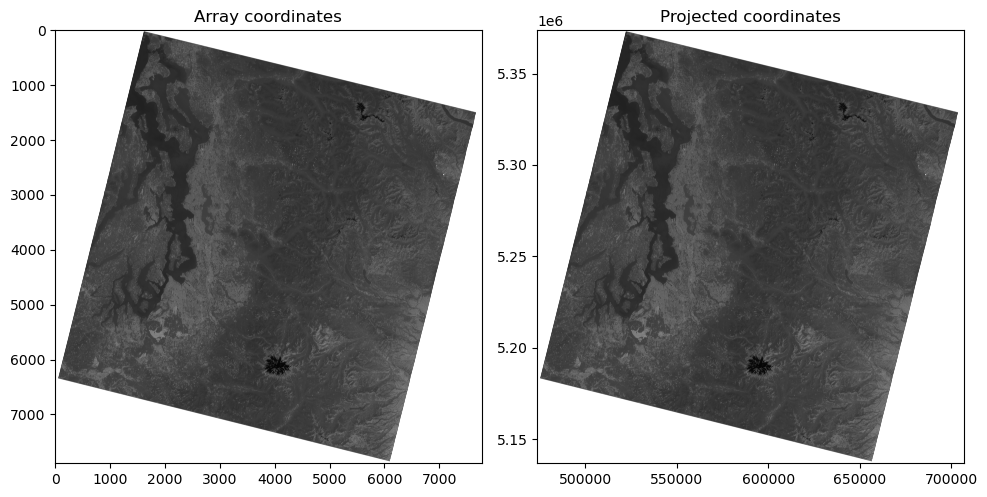

In [39]:
f, axa = plt.subplots(1,2, figsize=(10,6))
axa[0].imshow(a, cmap='gray') #vmin=0, vmax=1
axa[0].set_title("Array coordinates")
axa[1].imshow(a, extent=full_extent, cmap='gray') #vmin=0, vmax=1
axa[1].set_title("Projected coordinates")
f.tight_layout()

### Raster transform
* How does rasterio know the bounds?
* Inspect the dataset `transform` attribute
* You may have encountered an ESRI "world file" or GDAL geotransform before. This is the same idea, but Rasterio's model uses traditional affine transform.
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

In [40]:
src.transform

Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0)

In [41]:
#These are (x,y) for corners in image/array coordinates (pixels)
#A bit confusing due to (row,col) of shape, which is (y,x)

#Upper left
ul = (0, 0)
#One pixel from upper left
ul1 = (1,1)
#Lower right
lr = (a_st.shape[1], a_st.shape[0])

print(ul, ul1, lr)

(0, 0) (1, 1) (7771, 7891)


In [42]:
#Transform upper left corner to projected coordinates (meters)
print(ul)
ul_proj = src.transform * ul
print(ul_proj)

(0, 0)
(473685.0, 5373615.0)


In [43]:
#Transform the one pixel offset from ul to projected coordinates (meters)
print(ul1)
ul1_proj = src.transform * ul1
print(ul1_proj)

(1, 1)
(473715.0, 5373585.0)


In [44]:
np.array(ul_proj) - np.array(ul1_proj)

array([-30.,  30.])

In [45]:
#Transform lower right corner
print(lr)
lr_proj = src.transform * lr
print(lr_proj)

(7771, 7891)
(706815.0, 5136885.0)


In [46]:
wh_km = np.abs(np.array(ul_proj) - np.array(lr_proj))/1000
wh_km
print('Total width: %0.2f km\nTotal height: %0.2f km' % (wh_km[0], wh_km[1]))

Total width: 233.13 km
Total height: 236.73 km


### Reprojection
Rasterio documentation [here](https://rasterio.readthedocs.io/en/stable/topics/reproject.html#reprojecting-a-geotiff-dataset).

In [47]:
dst_crs = 'EPSG:4326'

transform, width, height = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = src.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})

with rasterio.open(tir_august_4326_fn, 'w', **kwargs) as dst:
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

### Raster and array sampling
* Use helper functions `xy` and `sample`

In [48]:
a_st

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [49]:
a_st[0,0]

masked

In [50]:
#Array coordinates
c = (3512, 3512)

In [51]:
#Get value at coordinates using array indexing
a_st[c[0], c[1]]

23.241858

In [52]:
#src.xy?

In [53]:
#Note use of argument expansion here (*c) so we don't have to pass individual c[0] and c[1] values
x,y = src.xy(*c)
print(x,y)

579060.0 5268240.0


In [54]:
#a_st[int(x), int(y)]

In [55]:
#src.sample?

In [56]:
#Doesn't actually produce coordinates
src.sample(x, y)

<generator object sample_gen at 0x7f64ed9df850>

In [57]:
#Doesn't work - need to pass in list
#list(src.sample(x, y))

In [58]:
src.sample([(x, y),])

<generator object sample_gen at 0x7f64ed9dfb30>

In [59]:
#Pass in a list of (x,y) coordinate pairs, and evaluate the generator
list(src.sample([(x, y),]))

[array([43122], dtype=uint16)]

In [60]:
s = list(src.sample([(x, y), (x+30, y+30), (x-30, y-30)]))
s

[array([43122], dtype=uint16),
 array([43144], dtype=uint16),
 array([43093], dtype=uint16)]

In [61]:
s[0]

array([43122], dtype=uint16)

In [62]:
np.array(s).squeeze()

array([43122, 43144, 43093], dtype=uint16)

### Windowing and indexing

In [63]:
chunk = a_st[2700:3800,2200:3000]
chunk

masked_array(
  data=[[15.855517387390137, 15.930713653564453, 16.036672592163086, ...,
         33.80695724487305, 33.171207427978516, 33.08575439453125],
        [15.927295684814453, 15.98198413848877, 16.050344467163086, ...,
         33.60187530517578, 32.596981048583984, 32.29277420043945],
        [15.99565601348877, 16.029836654663086, 16.077688217163086, ...,
         33.41730499267578, 32.17656326293945, 31.63651466369629],
        ...,
        [22.681303024291992, 22.616361618041992, 22.60610580444336, ...,
         30.946075439453125, 28.891845703125, 27.948471069335938],
        [22.900056838989258, 22.715482711791992, 22.691556930541992, ...,
         30.67947006225586, 29.110599517822266, 28.5192813873291],
        [22.947908401489258, 22.718900680541992, 22.732572555541992, ...,
         30.580347061157227, 30.026628494262695, 29.83521842956543]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [Fa

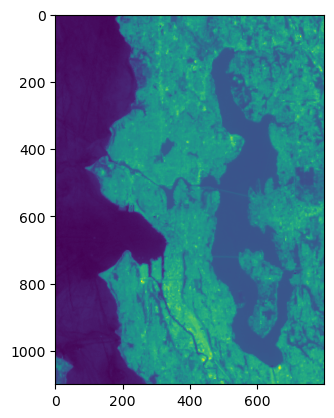

In [64]:
f, ax = plt.subplots()
plt.imshow(chunk, interpolation='none')

### Store a reduced resolution view (1 pixel for every 100 original pixels)

In [65]:
asub = a_st[::10, ::10]
asub

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [66]:
asub.shape

(790, 778)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


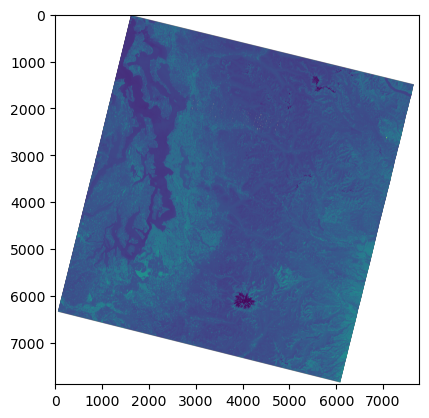

In [67]:
%time
f, ax = plt.subplots()
plt.imshow(a_st);

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


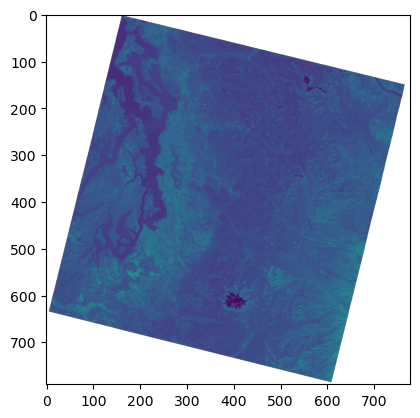

In [68]:
#Every 10th pixel - great strategy for quick visualization during development/exploration
%time
f, ax = plt.subplots()
plt.imshow(asub);

### Reading in reduced resolution overview from the start
* Since we have a cloud optimized geotiff (COG), can directly read the embedded overviews, rather than full resolution data
* Easier with rioxarray (later)

In [69]:
ovr_level = 8 #power of 2 (see gdalinfo above for overview dimensions)
ovr_shape = (int(src.height/ovr_level), int(src.width/ovr_level))

In [70]:
#Note memory usage before and after reading
%time
a_ovr = src.read(1, out_shape=ovr_shape)

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.81 μs


In [71]:
t = src.transform
t

Affine(30.0, 0.0, 473685.0,
       0.0, -30.0, 5373615.0)

In [72]:
#Should assign this to new dataset/profile for ovr (or just use rioxarray)
import affine
ovr_transform = affine.Affine(t[0]*ovr_level, t[1], t[2], t[3], t[4]*ovr_level, t[5])
ovr_transform

Affine(240.0, 0.0, 473685.0,
       0.0, -240.0, 5373615.0)

In [73]:
a.shape

(7891, 7771)

In [74]:
a_ovr.shape

(986, 971)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 μs


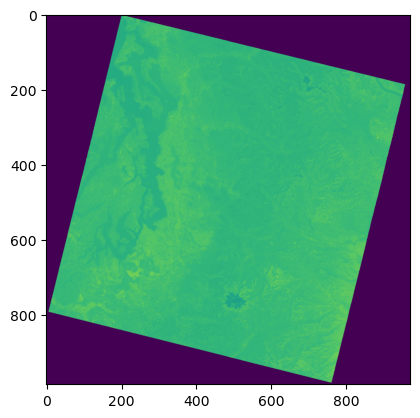

In [75]:
%time
f, ax = plt.subplots()
plt.imshow(a_ovr);

### Raster math

In [76]:
#%matplotlib widget

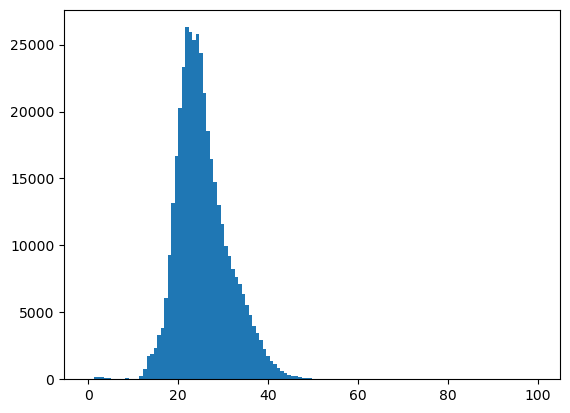

In [77]:
#Remember to use compressed for historgrams with 2D masked arrays
f, ax = plt.subplots()
plt.hist(asub.compressed(), bins=128);

In [78]:
t_thresh = 18 #Deg C

In [79]:
asub

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [80]:
#Identifiy pixels with values less than some threshold
asub < t_thresh

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=False)

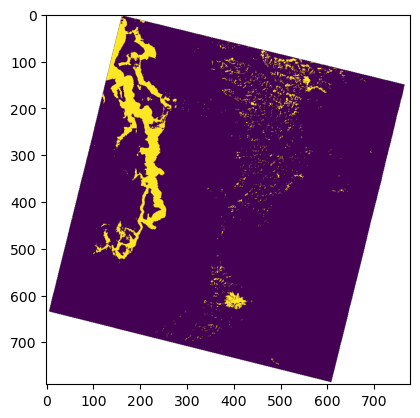

In [81]:
f, ax = plt.subplots()
plt.imshow(asub <= t_thresh);

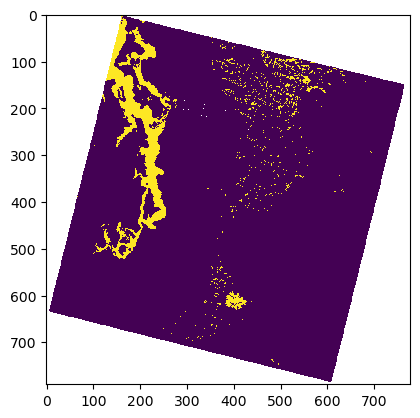

In [82]:
#Use nearest neighbor interpolation for binary raster data!
plt.imshow(asub <= t_thresh, interpolation='none');

### Calculating area

In [83]:
a_st.size

61320961

In [84]:
a_st.compressed().size

40633950

In [85]:
a_st.count()

40633950

In [86]:
#Count up nonzero values - somewhat complicated way
(a_st <= t_thresh).nonzero()[0].size

2512952

In [87]:
#Sum the boolean values (True = 1, False = 0)
n_px = (a_st <= t_thresh).sum()
n_px

2512952

In [88]:
src.res

(30.0, 30.0)

In [89]:
#Ground sample distance for a single pixel in meters
src.res

(30.0, 30.0)

In [90]:
#Area of single pixel (m^2)
px_area = src.res[0] * src.res[1]
px_area

900.0

In [91]:
n_px * px_area

2261656800.0

### How could we create an RGB image?
#### Set up a window

In [92]:
import rasterio.windows

#Mt. Rainier
window = rasterio.windows.Window(3600, 5600, 1024, 1024)

window_bounds = rasterio.windows.bounds(window,transform=src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (581685.0, 5174895.0, 612405.0, 5205615.0)
Window extent:  [581685.0, 612405.0, 5174895.0, 5205615.0]


#### Read in the red green and blue band as masked arrays

In [93]:
#Red
r_fn = os.path.join(imgdir, august_id+'_SR_B4.TIF')
#Green
g_fn = os.path.join(imgdir, august_id+'_SR_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, august_id+'_SR_B2.TIF')

In [94]:
def rio2ma(fn, b=1, window=None, scale=True):
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        #If Level 2 surface reflectance and surface temperature, scale values appropriately
        if scale:
            if 'SR' in fn:
                #Output in unitless surface reflectance from 0-1
                a = a * sr_scale + sr_offset
            elif 'ST' in fn:
                #Output in degrees Celsius
                a = a * st_scale + st_offset - 273.15
            a = a.astype('float32')
        return a

In [95]:
r = rio2ma(r_fn, window=window)
g = rio2ma(g_fn, window=window)
b = rio2ma(b_fn, window=window)

#### Normalize each array individually to contrast stretch the final image

In [96]:
def norm(a, perc_lim=(2, 98), clip=True, verbose=True):
    #Simple approach using actual min and max values
    #amin, amax = (a.min(), a.max())
    #Check if we're using masked array or np.nan
    if np.ma.isMaskedArray(a):
        amin, amax = np.percentile(a.compressed(), perc_lim)
    else:
        amin, amax = np.nanpercentile(a, perc_lim)
    out = ((a - amin)/(amax - amin))
    #This will "clip" normalized values <0 to 0 and >1 to 1
    if clip:
        out = out.clip(0,1)
    if verbose:
        print("Input range: ({}, {})".format(a.min(), a.max()))
        print(f"Percentile range {perc_lim}: ({amin}, {amax})")
        print("Output range: ({}, {})".format(out.min(), out.max()))
    return out

In [97]:
perc = (0, 95)

r_norm = norm(r, perc)
g_norm = norm(g, perc)
b_norm = norm(b, perc)

Input range: (-0.009864999912679195, 0.9770824909210205)
Percentile range (0, 95): (-0.009864999912679195, 0.3119949996471405)
Output range: (0.0, 1.0)
Input range: (-0.01294500008225441, 0.9627825021743774)
Percentile range (0, 95): (-0.01294500008225441, 0.279215008020401)
Output range: (0.0, 1.0)
Input range: (-0.07380250096321106, 0.8930699825286865)
Percentile range (0, 95): (-0.07380250096321106, 0.23955999314785004)
Output range: (0.0, 1.0)


#### Stack the bands together

In [98]:
rgb = np.dstack([r_norm,g_norm,b_norm])
print(rgb.shape)

(1024, 1024, 3)


#### Display!

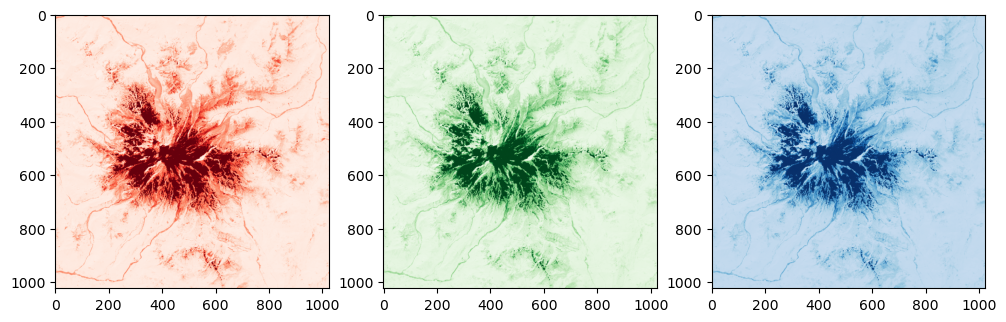

In [99]:
f, axa = plt.subplots(1,3, figsize=(12,4))
axa[0].imshow(rgb[:,:,0], cmap='Reds')
axa[1].imshow(rgb[:,:,1], cmap='Greens')
axa[2].imshow(rgb[:,:,2], cmap='Blues');

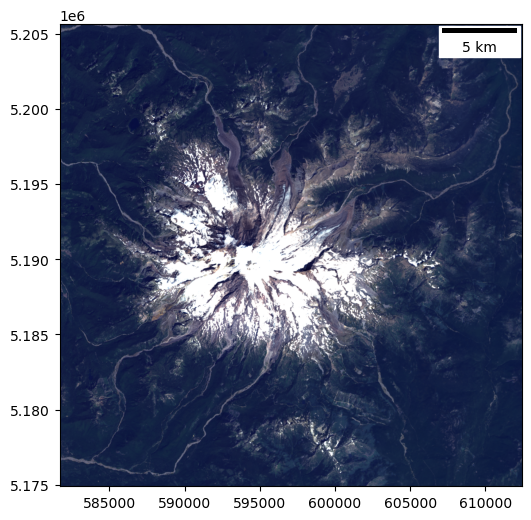

In [100]:
f, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgb, extent=window_extent)
ax.add_artist(ScaleBar(1.0));

### Cleanup and memory management

In [101]:
#Delete array from memory
a = None
a_st = None
asub = None

In [102]:
#Close the rasterio dataset
src.close()